In [1]:
%reload_ext autoreload
%autoreload 2

from skills_ml.ontologies.onet import majorgroupname

import os
import json
import statistics
import operator
from collections import Counter, defaultdict
from functools import reduce, partial
import logging
logging.basicConfig(level=logging.INFO)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set(style="darkgrid", font_scale=2)
%matplotlib inline

In [2]:
# some plotting functions
def plot_major_group_distribution(job_postings):
    c = Counter()
    for job in job_postings:
        c.update([job['onet_soc_code'][:2]])
    s = pd.Series(c).sort_index()
    s.index = s.index.map(majorgroupname)
    ax = s.plot.bar(figsize=(20,10),rot=90)
    ax.set_xlabel('soc_major_group')
    ax.set_ylabel('number of job posting')
    ax.set_title(f"total number: {s.sum()}")
    return s



def algorithm_name(emb):
    if emb.model_type == 'word2vec' or emb.model_type == 'fasttext':
        if getattr(emb, 'sg', None) == 1:
            return 'Skip-Gram'
        else:
            return 'Continuous Bag of Words'
        
    elif emb.model_type == 'doc2vec':
        if getattr(emb, 'dm', None) == 1:
            return 'Distributed Memory'
        else:
            return 'Distributed Bag of Words'


def evaluate(embeddings, vectorization, metric):
    result = defaultdict(dict)
    for emb in embeddings:
        c = metric.eval(vectorization(emb))
        name = emb.model_name.split('.')[0]
        result[name]['mean'] = statistics.mean(list(c.values()))
        result[name]['variance'] = statistics.variance(list(c.values()))
        result[name]['std'] = statistics.stdev(list(c.values()))
        result[name]['max'] = max(c.items(), key=operator.itemgetter(1))[1]
        result[name]['max_cluster'] = max(c.items(), key=operator.itemgetter(1))[0]
        result[name]['min'] = min(c.items(), key=operator.itemgetter(1))[1]
        result[name]['min_cluster'] = min(c.items(), key=operator.itemgetter(1))[0]
        result[name]['type'] = emb.model_type
        result[name]['algorithm'] = algorithm_name(emb)
        result[name]['window'] = emb.window
    
    return pd.DataFrame(result)


def itershuffle(iterable, bufsize=1000):
    """Shuffle an iterator. This works by holding `bufsize` items back
    and yielding them sometime later. This is NOT 100% random, proved or anything."""
    iterable = iter(iterable)
    buf = []
    try:
        while True:
            for i in range(random.randint(1, bufsize-len(buf))):
                buf.append(next(iterable))
            random.shuffle(buf)
            for i in range(random.randint(1, bufsize)):
                if buf:
                    yield buf.pop()
                else:
                    break
    except StopIteration:
        random.shuffle(buf)
        while buf:
            yield buf.pop()
        raise StopIteration

# Skills-ML Tour

Skills-ML is an open source software library for applying NLP and ML to labor market data. It allows the user to perform tasks like skill extraction and occupation classification to collections of documents such as job postings, profiles, and course descriptions.

## Competency

A competency is any expertise or talent that is useful for a job. Developed capacities (e.g. active listening), proficiency with tools or technology (e.g. lancets, Microsoft Word), innate abilities (e.g. originality), and academic knowledge (e.g. medicine) are all considered competencies.

In [3]:
from skills_ml.ontologies import Competency

dinosaur_riding = Competency(
    identifier='dino_riding',
    name='Dinosaur Riding',
    description='Using the back of a dinosaur for transportation'
)

### Competency Relationships

Competencies are often related to each other. Defining parent-child relationships is a standard building block of existing competency frameworks like ONET and ESCO. A parent-child relationship generally implies that the child is a "type of" the parent.

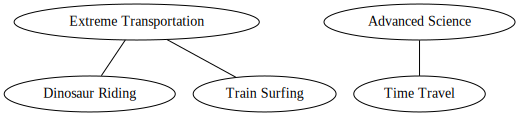

In [4]:
from skills_ml.ontologies import Competency
from skills_ml.ontologies.viz import display_nodes

dinosaur_riding = Competency(
    identifier='12345',
    name='Dinosaur Riding',
    description='Using the back of a dinosaur for transportation'
)

train_surfing = Competency(
    identifier='12346',
    name='Train Surfing',
    description='Standing on the train while it goes'
)

time_travel = Competency(
    identifier='23456',
    name='Time Travel',
    description='Traveling Through Time'
)

advanced_science = Competency(
    identifier='2345',
    name='Advanced Science',
)

extreme_transportation = Competency(
    identifier='123',
    name='Extreme Transportation',
    description='Comically dangerous forms of transportation'
)
time_travel.add_parent(advanced_science)
dinosaur_riding.add_parent(extreme_transportation)
train_surfing.add_parent(extreme_transportation)
display_nodes([dinosaur_riding, train_surfing, extreme_transportation, time_travel, advanced_science])

## Occupation

An occupation is a job or profession that a person can hold. Similar to competencies, these are also often defined hierarchically.


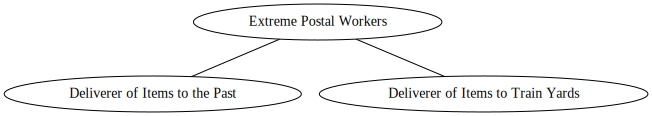

In [5]:
from skills_ml.ontologies import Occupation

extreme_postal_workers = Occupation(identifier='999', name='Extreme Postal Workers')
dino_postal_worker = Occupation(identifier='9998', name='Deliverer of Items to the Past')
train_yard_postal_worker = Occupation(identifier='9999', name='Deliverer of Items to Train Yards')
dino_postal_worker.add_parent(extreme_postal_workers)
train_yard_postal_worker.add_parent(extreme_postal_workers)

display_nodes([extreme_postal_workers, dino_postal_worker, train_yard_postal_worker])

# CompetencyOntology

A CompetencyOntology is a model of the labor market, or some subset thereof, consisting of a collection of competencies, a collection of occupations, and all of the relationships between them.

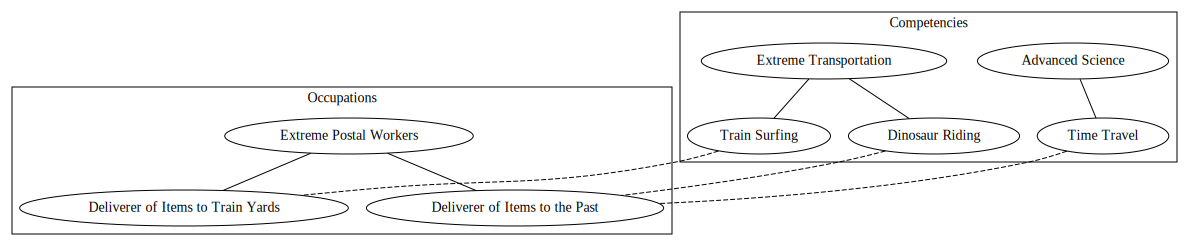

In [6]:
from skills_ml.ontologies import CompetencyOntology
from skills_ml.ontologies.viz import display_ontology

ontology = CompetencyOntology()
ontology.add_competency(dinosaur_riding)
ontology.add_competency(train_surfing)
ontology.add_competency(extreme_transportation)
ontology.add_competency(time_travel)
ontology.add_competency(advanced_science)

ontology.add_occupation(dino_postal_worker)
ontology.add_occupation(train_yard_postal_worker)
ontology.add_occupation(extreme_postal_workers)

ontology.add_edge(occupation=dino_postal_worker, competency=dinosaur_riding)
ontology.add_edge(occupation=dino_postal_worker, competency=time_travel)
ontology.add_edge(occupation=train_yard_postal_worker, competency=train_surfing)

display_ontology(ontology)

## Prebuilt Ontologies

To move on we'll want to level up to a full ontology. The example we'll use is O\*NET, built from survey data and maintained by the US Department of Labor. A CompetencyOntology subclass that downloads the source files from the O\*NET web site is included in Skills-ML.

In [7]:
from skills_ml.ontologies.onet import Onet
onet = Onet()
onet.print_summary_stats()

INFO:root:Manual build specified. Building O*NET CompetencyOntology via direct querying from O*NET site, or local cache.
INFO:root:Processing Content Model Reference
INFO:root:Processing occupation data
INFO:root:Processing Knowledge, Skills, Abilities
INFO:root:Processing tools and technology


Ontology summary statistics for onet
Num competencies: 32030
Num occupations: 1133
Num competency-occupation edges: 107305
Median occupations per competency: 1
Median competencies per occupation: 89
Mean occupations per competency: 3.350245090386837
Mean competencies per occupation: 94.70873786407768


In [8]:
list(onet.competencies)[0:5]

[Competency(identifier=41121701-Laboratory test tubes, name=Laboratory test tubes, categories=['Tools', 'O*NET T2'], {}),
 Competency(identifier=41111905-Inductive probes, name=Inductive probes, categories=['Tools', 'O*NET T2'], {}),
 Competency(identifier=41113704-Backplane testers, name=Backplane testers, categories=['Tools', 'O*NET T2'], {}),
 Competency(identifier=41112302-Wet bulb thermometers, name=Wet bulb thermometers, categories=['Tools', 'O*NET T2'], {}),
 Competency(identifier=41102704-Cone-beam collimators, name=Cone-beam collimators, categories=['Tools', 'O*NET T2'], {})]

### Filtering

~34000 competencies and ~1100 occupations is a lot. Let's explore the filtering functionality of the CompetencyOntology to zoom in on a more specific slice.

`filter_by` filters using edges: the filtering function it expects takes in an edge (between a Competency and Occupation) and returns whether or not it should be in the result. The result takes the form of a new CompetencyOntology, so you can interact with it in the same way as you would the source ontology. 

In [9]:
nurse_practitioners = onet.filter_by(lambda edge: 'Nurse Practitioners' in edge.occupation.name)
nurse_practitioners.competencies

{Competency(identifier=1.A.1.a.1, name=Oral Comprehension, categories=['Abilities'], {'competencyText': 'The ability to listen to and understand information and ideas presented through spoken words and sentences.'}),
 Competency(identifier=1.A.1.a.2, name=Written Comprehension, categories=['Abilities'], {'competencyText': 'The ability to read and understand information and ideas presented in writing.'}),
 Competency(identifier=1.A.1.a.3, name=Oral Expression, categories=['Abilities'], {'competencyText': 'The ability to communicate information and ideas in speaking so others will understand.'}),
 Competency(identifier=1.A.1.a.4, name=Written Expression, categories=['Abilities'], {'competencyText': 'The ability to communicate information and ideas in writing so others will understand.'}),
 Competency(identifier=1.A.1.b.1, name=Fluency of Ideas, categories=['Abilities'], {'competencyText': 'The ability to come up with a number of ideas about a topic (the number of ideas is important, not 

That's a big list of competencies. Each competency has a list of categories, so let's get all of the different possible categories

In [10]:
set(cat for competency in nurse_practitioners.competencies for cat in competency.categories)

{'Abilities', 'Knowledge', 'O*NET T2', 'Skills', 'Technology', 'Tools'}

So we can ask questions like: what type of Knowledge do nurse practitioners need?

In [11]:
[competency for competency in nurse_practitioners.competencies if 'Knowledge' in competency.categories]

[Competency(identifier=2.C.5.a, name=Medicine and Dentistry, categories=['Knowledge'], {'competencyText': 'Knowledge of the information and techniques needed to diagnose and treat human injuries, diseases, and deformities. This includes symptoms, treatment alternatives, drug properties and interactions, and preventive health-care measures.'}),
 Competency(identifier=2.C.7.a, name=English Language, categories=['Knowledge'], {'competencyText': 'Knowledge of the structure and content of the English language including the meaning and spelling of words, rules of composition, and grammar.'}),
 Competency(identifier=2.C.4.a, name=Mathematics, categories=['Knowledge'], {'competencyText': 'Knowledge of arithmetic, algebra, geometry, calculus, statistics, and their applications.'}),
 Competency(identifier=2.C.4.e, name=Psychology, categories=['Knowledge'], {'competencyText': 'Knowledge of human behavior and performance; individual differences in ability, personality, and interests; learning and 

There are many other questions we can ask of just an ontology, but the real value will come from combining the knowledge contained in the ontology with larger unstructured datasets. In this next section we will explore how Skills-ML helps the user deal with such datasets as job postings, profiles, or course descriptions.

# Spirit of Skills-ML

- **Dataflow Programming**: `Skills-ML`'s design philosophy builds on dataflow programming or so called data streaming to process very large datasets (larger than RAM; potentially infinite). 
- **One-pass algorithm**: Data points are processed one at a time.
- **Lazy evaluation**: an evaluation strategy which delays the evaluation of an expression until its value is needed. In `Skills-ML`, most of the classes and functions here incorporates the concept of `Iterable` or `Generator`. We build the expression first and evaluate later. 

# Creating Dataset

Before we do anything with the context, we need dataset. `Skills-ML` makes use of schema.org’s JobPosting standard. As it has been in use for a long time, some open sources are already using this standard, which is easy to import. Other job posting data sources are converted into the schema.org Schema and all work on job postings is done using this standard schema. 

In `Skills-ML`, `job_postings` module has all the functionalities to create the data we need for later usage. 

## Common Schema

We have an useful function to help create the data generator from s3. 

- `JobPostingCollectionFromS3`: Stream job posting from s3.
- `JobPostingCollectionSample`: Stream a finite number of job postings stored within the library.

However, we are not restrcted to just JobPosting data. One can easily create whatever data generator such as `ProfileGenerator` or `CourseGenerator`. 

For example, we want to use the Vrigina Dataset which is an open data set of job postings. We just have to create a job posting generator with some transformation. 

In [12]:
from skills_ml.job_postings.raw.virginia import VirginiaTransformer
from urllib.request import urlopen

va_url = "http://opendata.cs.vt.edu/dataset/ab0abac3-2293-4c9d-8d80-22d450254389/resource/074f7e44-9275-4bba-874e-4795e8f6830c/download/openjobs-jobpostings.may-2016.json"

class VAJobposting(object):
    def __init__(self, uri):
        self.uri = uri
    
    def __iter__(self):
        request = urlopen(self.uri)
        for line in request.readlines():
            raw = json.loads(line)
            yield VirginiaTransformer(partner_id="va")._transform(raw)
            

jobpostings_va = VAJobposting(va_url)

INFO:summarizer.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English


In [13]:
print(len(list(jobpostings_va)))

40098


## Filtering

To create a good dataset, we might want to have some criteria for choosing the proper job posting based on the task we want to perform, like job postings that have the label information, job postings that belong to certain occupation, or job postings that have rich enough information in the description field.

- `JobPostingFilterer`: Filter common schema job postings through a number of filtering functions.

This function also follows lazy evaluation strategy.

In [14]:
from skills_ml.job_postings.filtering import JobPostingFilterer

def is_tech_jobs(job):
    if job['onet_soc_code'][:2] in ['15', '17', '19']:
        return True
    else:
        return False
    
tech_jobs = JobPostingFilterer(
    job_posting_generator=VAJobposting(va_url), 
    filter_funcs=[is_tech_jobs]
)

Computer and Mathematical             5065
Architecture and Engineering          1937
Life, Physical, and Social Science     192
dtype: int64

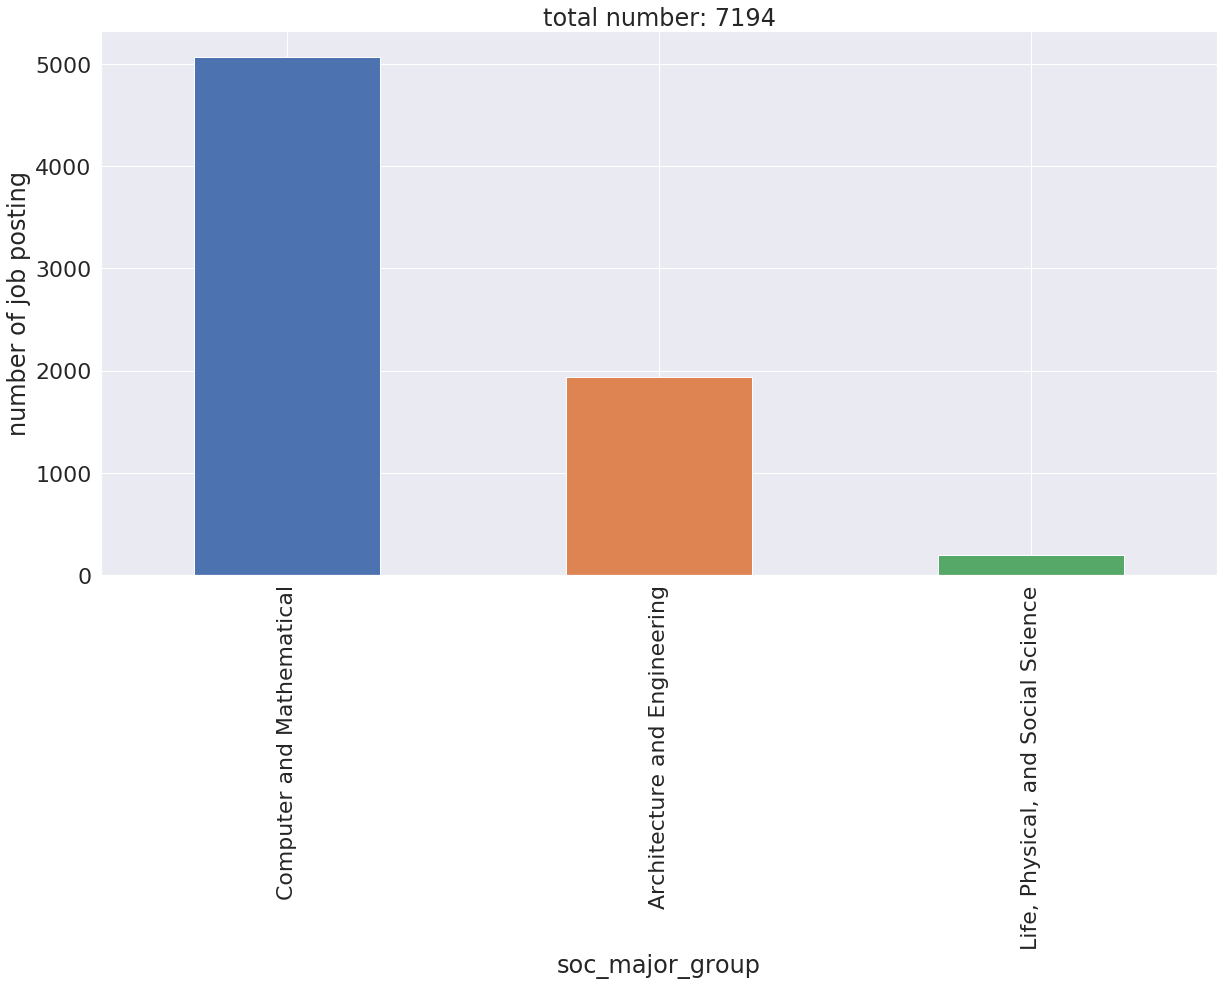

In [15]:
plot_major_group_distribution(tech_jobs)

What if we want to make sure that all the job postings have ONet SOC Code and it's not unknown(first 2 digit 99)? We can define filter functions like these which can be either generic function or lambda function.

In [16]:
def filter_onet_soc_code(job):
    if job['onet_soc_code'] and job['onet_soc_code'][:2] != '99':
        return True
    else:
        return False

has_soc = lambda x: x['onet_soc_code']
not_unknown_soc = lambda x: x['onet_soc_code'][:2] != '99'

In [17]:
jobpostings_filtered = JobPostingFilterer(
    job_posting_generator=VAJobposting(va_url), 
    filter_funcs=[has_soc, not_unknown_soc]
)

Management                                        6506
Business and Financial Operations                 3867
Computer and Mathematical                         5065
Architecture and Engineering                      1937
Life, Physical, and Social Science                 192
Community and Social Service                       282
Legal                                               94
Education, Training, and Library                   679
Arts, Design, Entertainment, Sports, and Media     598
Healthcare Practitioners and Technical            3447
Healthcare Support                                 494
Protective Service                                 484
Food Preparation and Serving Related               792
Building and Grounds Cleaning and Maintenance      189
Personal Care and Service                           97
Sales and Related                                 1415
Office and Administrative Support                 2580
Construction and Extraction                        196
Installati

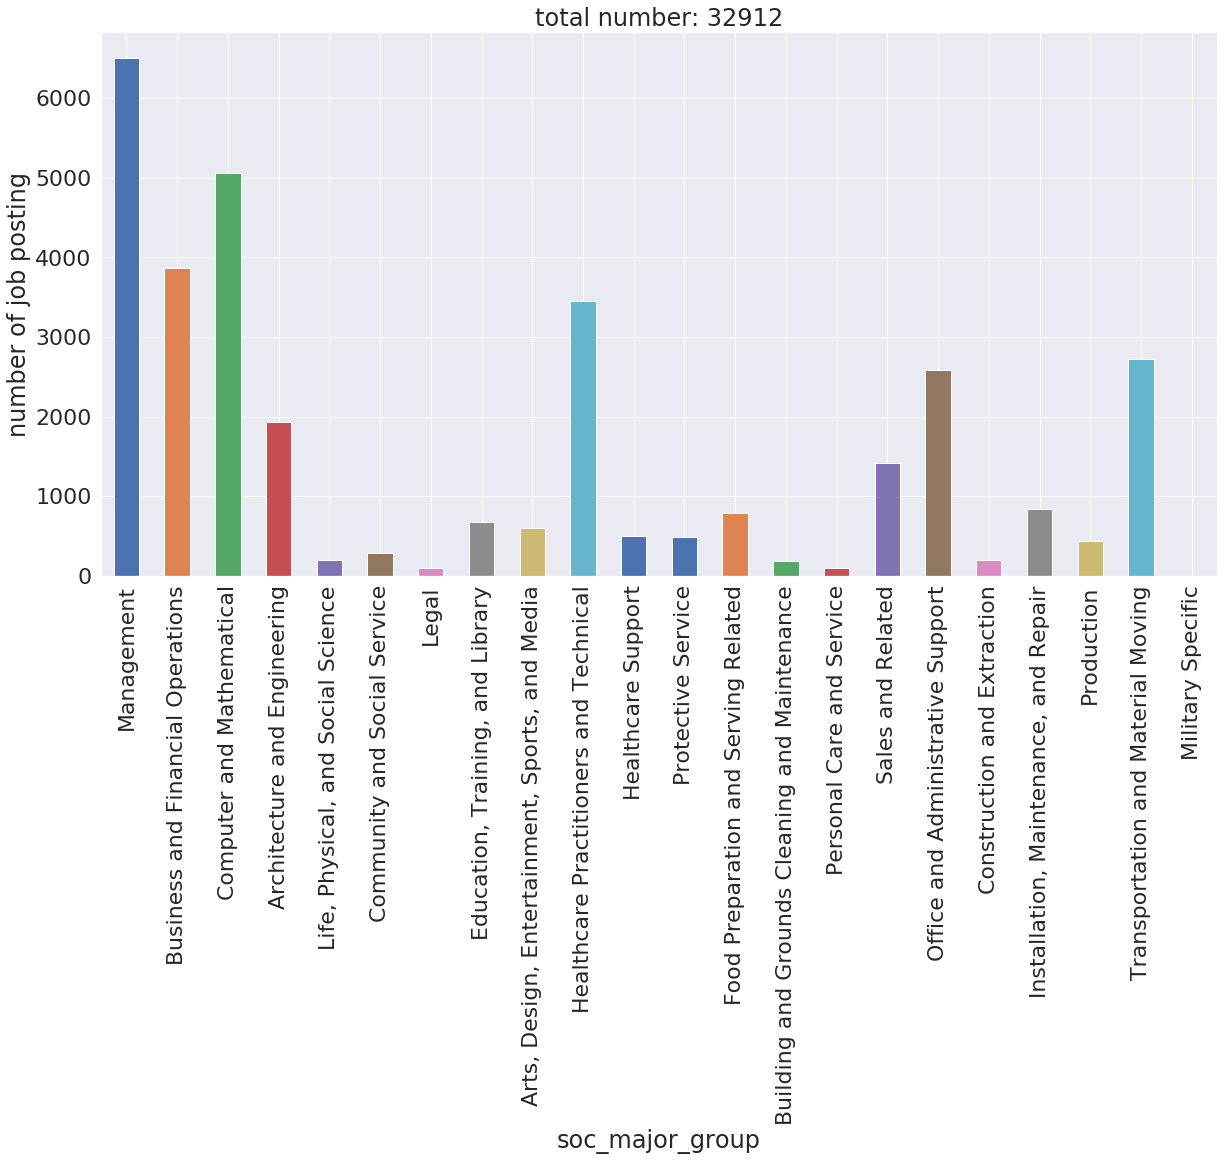

In [18]:
plot_major_group_distribution(jobpostings_filtered)

## Random Sampling

Even though we have a lot of data, most of time we don't need all of them to do the analysis. Or we can't even fit all the data into memory to do the analysis. What we need more importantly is a suitable sampled dataset.

- `JobSampler`: Sample job posting by (weighted) reservoir sampling. 

### Random Sampling from Streaming Data - Reservoir Sampling

- "Say you have a stream of items of large and unknown length that we can only iterate over once."
- It's memeory efficient and just one iteration
- There is a great overview of reservoir sampling in https://gregable.com/2007/10/reservoir-sampling.html. 

Let's say the original job postings dataset are too much for my Mac Yosemite to do any analysis and I want only 1000 job postings but still preserve the statistical characteristics of the original dataset. 

In [23]:
from skills_ml.job_postings.sample import JobSampler

sampler = JobSampler(
    job_posting_generator=jobpostings_filtered, 
    k=1000,
)

Management                                        213
Business and Financial Operations                 127
Computer and Mathematical                         141
Architecture and Engineering                       60
Life, Physical, and Social Science                  5
Community and Social Service                        6
Legal                                               3
Education, Training, and Library                   13
Arts, Design, Entertainment, Sports, and Media     16
Healthcare Practitioners and Technical             96
Healthcare Support                                 17
Protective Service                                 19
Food Preparation and Serving Related               28
Building and Grounds Cleaning and Maintenance       6
Personal Care and Service                           6
Sales and Related                                  50
Office and Administrative Support                  66
Construction and Extraction                         4
Installation, Maintenance, a

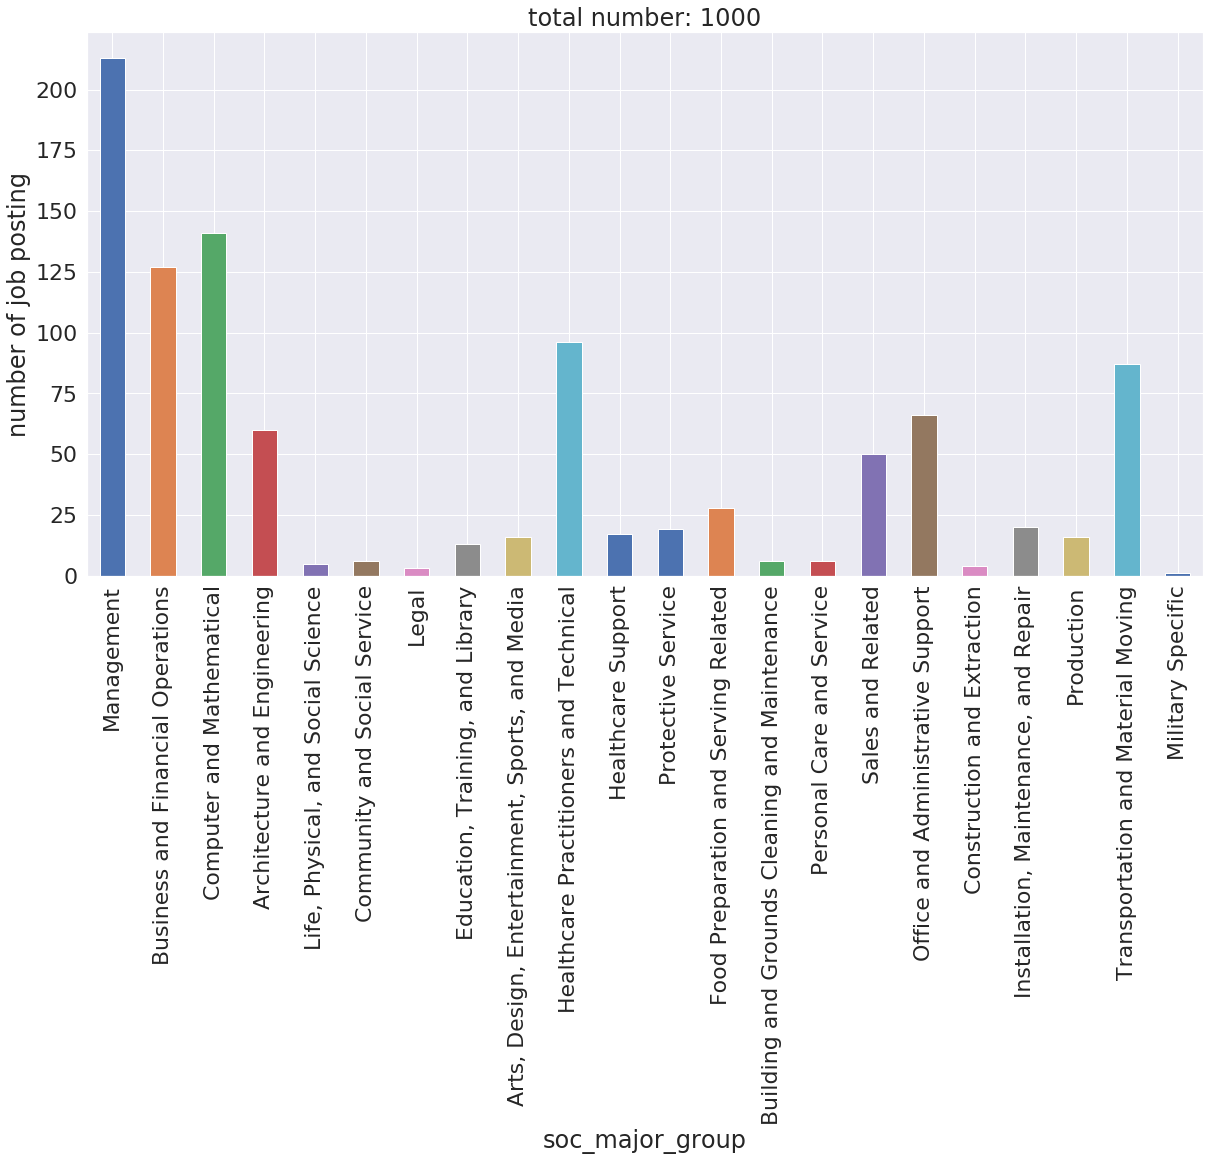

In [24]:
plot_major_group_distribution(sampler)

Something wrong happened! We are missing `Military Occupations`! Because military job postings are extremely rare in the original dataset, simple ramdom sampling might result in lack of classes.

## Weighted Reservoir Sampling

- How would you sample from a weighted distribution where each element has a given weight associated with it in the stream?

- For certain task, we need some curated sample. For example, if we want to build a occupation classifier, we want similar amounts of job posting for each occupation. 

Now we want to have a more uniform distributed sample across all major groups. 
Here we need to provide a weight dictionary in the `JobSampler`

In [25]:
c = Counter()
for job in jobpostings_filtered:
    c.update([job['onet_soc_code'][:2]])
weights = dict()
for key, value in c.items():
    weights[key] = max(c.values()) / value

In [26]:
weights

{'11': 1.0,
 '15': 1.2845014807502468,
 '17': 3.3588022715539494,
 '29': 1.8874383521903104,
 '41': 4.597879858657244,
 '43': 2.521705426356589,
 '13': 1.6824411688647531,
 '49': 7.819711538461538,
 '33': 13.442148760330578,
 '27': 10.879598662207357,
 '47': 33.19387755102041,
 '51': 14.71945701357466,
 '35': 8.214646464646465,
 '25': 9.581737849779087,
 '31': 13.17004048582996,
 '19': 33.885416666666664,
 '21': 23.070921985815602,
 '37': 34.423280423280424,
 '53': 2.3901542983100663,
 '39': 67.0721649484536,
 '23': 69.2127659574468,
 '55': 3253.0}

In [50]:
sampler = JobSampler(job_posting_generator=jobpostings_filtered, k=1000, key=lambda x: x['onet_soc_code'][:2], weights=weights)

Management                                        53
Business and Financial Operations                 42
Computer and Mathematical                         49
Architecture and Engineering                      42
Life, Physical, and Social Science                46
Community and Social Service                      53
Legal                                             38
Education, Training, and Library                  47
Arts, Design, Entertainment, Sports, and Media    45
Healthcare Practitioners and Technical            46
Healthcare Support                                47
Protective Service                                52
Food Preparation and Serving Related              52
Building and Grounds Cleaning and Maintenance     45
Personal Care and Service                         45
Sales and Related                                 60
Office and Administrative Support                 48
Construction and Extraction                       44
Installation, Maintenance, and Repair         

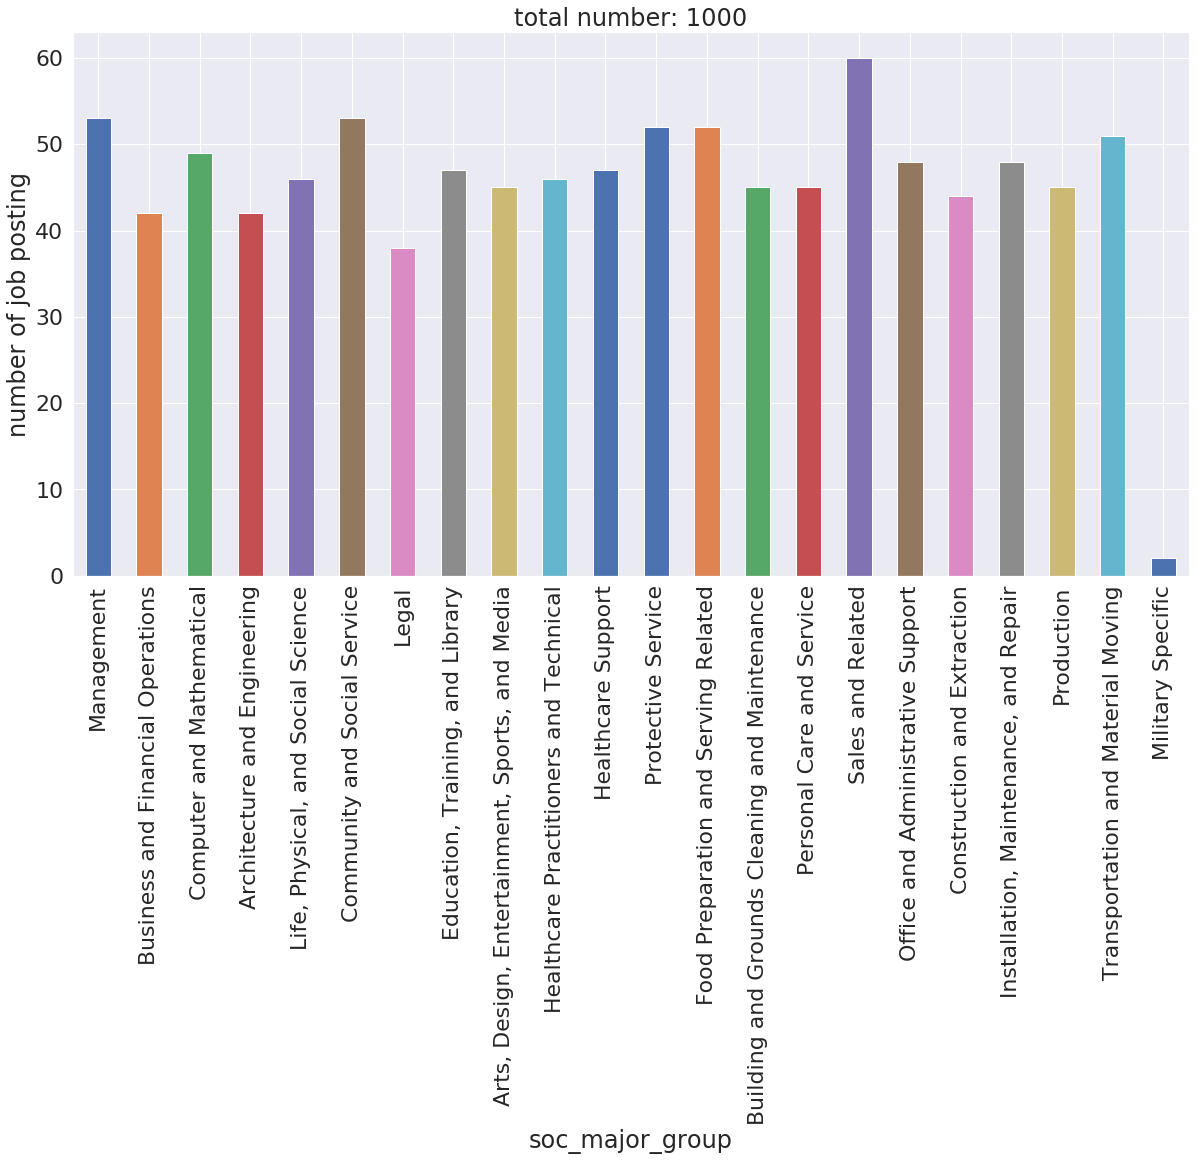

In [51]:
plot_major_group_distribution(sampler)

# Skill Extraction

A common task is extracting competencies from unstructured text. Sometimes this is ontology-based (finding concepts from a known ontology in text), but this is not necessarily true. Skills-ML unites these with a common interface in the SkillExtractor class. The common interface is that every SkillExtractor needs to be able to take in a collection of documents, and yield what we call `CandidateSkill` objects.

## What Is a CandidateSkill?

A CandidateSkill is a possible occurrence of a skill/competency in context in some document. It consists of the following fields:

`skill_name` - The text version of the skill as it appears in the document

`matched_skill_identifier` - A reference to the skill in some ontology. This may be empty, if no ontology was used to search for skills.

`context` - The text surrounding the skill in the document. The goal is for a human labeler to be able to use this to determine whether or not the occurrence represents a true skill. How much context is included is up to the algorithm.

`start_index` - The start index of the skill occurrence within the document string.

`confidence` - The confidence level the algorithm has in this candidate skill being a true occurrence of a skill. This may be empty, if the algorithm has now way of producing a confidence value.

`document_id` - A unique identifier for the source document.

`document_type` - The type of document (examples: Job Posting, Profile, Course Description)

`source_object` - The entire source document.

`skill_extractor_name` - The name of the skill extractor algorithm. Every SkillExtractor subclass defines a name property that is used to give processes downstream context about how their output data was produced.

The idea behind the CandidateSkill object is to serve as a common interface between SkillExtractor objects, automatic evaluation methods, and manual evaluation methods.

- A labeling interface might intake CandidateSkill objects for humans to say yes/no to.
- Another type of labeling interface might involve the export of CandidateSkill objects based on what a human highlighted in the interface when shown the entire document
- Unsupervised evaluation metrics may take in one set of CandidateSkills to produce simple descriptive metrics
- Supervised evaluation metrics may take in one set of CandidateSkills from a SkillExtractor and another set of CandidateSkills from a human labeling interface and use the latter to evaluate the former

We'll talk about some of these use cases in more detail later. But for now, let's start with a simple example that uses NLP rules and isn't tied to an ontology. Let's define a method for extracting skills as 'all noun phrases that end in the word skill or skills'. This is a simple method that realistically won't cover all possible occurrences of skills, but this is a start.

In [31]:
from skills_ml.algorithms.skill_extractors import SkillEndingPatternExtractor
from skills_ml.job_postings.common_schema import JobPostingCollectionSample
job_posting_generator = JobPostingCollectionSample()
# instantiate the skill extractor. This class defaults to only considering lines that
# start with a bullet, which doesn't work for this dataset. So we set this flag to False.
skill_extractor = SkillEndingPatternExtractor(only_bulleted_lines=False)
job_posting = next(iter(job_posting_generator))
for candidate_skill in skill_extractor.candidate_skills(job_posting):
    print('skill name:', candidate_skill.skill_name)
    print('context:', candidate_skill.context)
    print('')

INFO:root:Yielding candidate skill communication skills in context Excellent client presentation and communication skills as well as strong customer service and organizational skills.
INFO:root:Yielding candidate skill organizational skills in context Excellent client presentation and communication skills as well as strong customer service and organizational skills.
INFO:root:Yielding candidate skill communication skills in context We are proud to be an equal opportunity employer College degree preferred, 2 - 5 years experience in print and / or online advertising sales and be able to show consistent sales results in previous positions, Knowledge of the IT industry is preferred, Track record of creativity in sales approaches and solutions, Track record of successfully meeting and exceeding sales goals in media sales relevant to 1105 Medias line of business, Excellent client presentation and communication skills as well as strong customer service and organizational skills, The ideal can

skill name: communication skills
context: Excellent client presentation and communication skills as well as strong customer service and organizational skills.

skill name: organizational skills
context: Excellent client presentation and communication skills as well as strong customer service and organizational skills.

skill name: communication skills
context: We are proud to be an equal opportunity employer College degree preferred, 2 - 5 years experience in print and / or online advertising sales and be able to show consistent sales results in previous positions, Knowledge of the IT industry is preferred, Track record of creativity in sales approaches and solutions, Track record of successfully meeting and exceeding sales goals in media sales relevant to 1105 Medias line of business, Excellent client presentation and communication skills as well as strong customer service and organizational skills, The ideal candidate is energetic, self - motivated, team - oriented, and customer - ce

The results for one job posting are modest. Two distinct skill names, each occurring two different times in the document.  This is a start.

Now let's try another skill extractor: matching with ONET data.

In [32]:
from skills_ml.algorithms.skill_extractors import ExactMatchSkillExtractor
skill_extractor = ExactMatchSkillExtractor(onet.competency_framework)
for candidate_skill in skill_extractor.candidate_skills(job_posting):
    print('skill name:', candidate_skill.skill_name)
    print('context:', candidate_skill.context)
    print('')

INFO:root:Found 32029 entries for lookup
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(34, 38), match='self'> in string The ideal candidate is energetic, self-motivated, team-oriented, and customer-centric.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(582, 586), match='self'> in string We are proud to be an equal opportunity employer College degree preferred, 2-5 years experience in print and/or online advertising sales and be able to show consistent sales results in previous positions, Knowledge of the IT industry is preferred, Track record of creativity in sales approaches and solutions, Track record of successfully meeting and exceeding sales goals in media sales relevant to 1105 Medias line of business, Excellent client  presentation and communication skills as well as strong customer service and organizational skills, The ideal candidate is energetic, self-motivated, team-oriented, and customer-centric, Understanding of how to research potential cust

skill name: self
context: The ideal candidate is energetic, self-motivated, team-oriented, and customer-centric.

skill name: self
context: We are proud to be an equal opportunity employer College degree preferred, 2-5 years experience in print and/or online advertising sales and be able to show consistent sales results in previous positions, Knowledge of the IT industry is preferred, Track record of creativity in sales approaches and solutions, Track record of successfully meeting and exceeding sales goals in media sales relevant to 1105 Medias line of business, Excellent client  presentation and communication skills as well as strong customer service and organizational skills, The ideal candidate is energetic, self-motivated, team-oriented, and customer-centric, Understanding of how to research potential customers and use online analytics from a sales perspective, Weekly local travel to meet with clients/prospects is required, Minimal non local travel a few times a year is required



Yikes. What is this? As it turns out, ['Self' is a real programming language](https://en.wikipedia.org/wiki/Self_(programming_language)). But it's not applicable here. Simply searching for skill names has its limitations.

To help with this, there is also the SocScopedExactMatchSkillExtractor. This does exact matching, but only for the occupation that the document is tagged with. This, of course, is only applicable if the document has one. And it needs a full CompetencyOntology to work.

In [33]:
from skills_ml.algorithms.skill_extractors import SocScopedExactMatchSkillExtractor
skill_extractor = SocScopedExactMatchSkillExtractor(onet)
for candidate_skill in skill_extractor.candidate_skills(job_posting):
    print('skill name:', candidate_skill.skill_name)
    print('context:', candidate_skill.context)
    print('')

INFO:root:Found 32029 entries for lookup
INFO:root:Found 96 entries for lookup


No results. This is expected: For an occupation that is not related to computer programming, the language 'Self' is likely irrelevant.

Here's a list of all the other skill extractors available.

`FuzzyMatchSkillExtractor` - Similar to the ExactMatchSkillExtractor, but using a configurable edit distance to find skill names that are very close to the targets.

`AbilityEndingPatternExtractor` - Similar to the SkillEndingPatternExtractor, but finding noun phrases that end in 'ability' or 'abilities'.

`SectionExtractSkillExtractor` - Attempts to divide the text into sections with headers, which is a common pattern found in job postings. Return each individual sentence found in sections with certain headers (Skills, Competencies, Qualifications).

### Evaluating Skill Extractors

We want to be able to evaluate skill extractors. We may or may not have labeled skills but do want to be able to generate descriptive metrics either way.

In [34]:
from skills_ml.evaluation.skill_extraction_metrics import TotalOccurrences, TotalVocabularySize, OntologyCompetencyRecall

metrics = [
    TotalOccurrences(),
    TotalVocabularySize(),
    OntologyCompetencyRecall(onet)
]
exact_match_skill_extractor = ExactMatchSkillExtractor(onet.competency_framework) 
for metric in metrics:
    candidate_skills = []
    for job_posting in job_posting_generator:
        candidate_skills += list(exact_match_skill_extractor.candidate_skills(job_posting))
    
    print('metric:', metric.name, 'value:', metric.eval(candidate_skills, 50)) 

INFO:root:Found 32029 entries for lookup
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(34, 38), match='self'> in string The ideal candidate is energetic, self-motivated, team-oriented, and customer-centric.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(582, 586), match='self'> in string We are proud to be an equal opportunity employer College degree preferred, 2-5 years experience in print and/or online advertising sales and be able to show consistent sales results in previous positions, Knowledge of the IT industry is preferred, Track record of creativity in sales approaches and solutions, Track record of successfully meeting and exceeding sales goals in media sales relevant to 1105 Medias line of business, Excellent client  presentation and communication skills as well as strong customer service and organizational skills, The ideal candidate is energetic, self-motivated, team-oriented, and customer-centric, Understanding of how to research potential cust

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management & multi-tasking - must be able to perform multiple tasks and use time efficiently.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(29, 40), match='automobiles'> in string Perform minor diagnostics on automobiles as required.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(90, 96), match='brakes'> in string Repair vehicles according to manufacturers' specifications including, but not limited to, brakes, suspension, exhaust, drive train, cooling system, tires, alignments, air conditioning/heating, ignition system, and fuel system.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(58, 69), match='automobiles'> in string This position performs minor repairs and lube services to automobiles.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(74, 85), match='automobiles'> in string Responsibilities include: perform oil changes 

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(22, 36), match='transportation'> in string Package materials for transportation, including Hazmat Materials IAW PWS requirements.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(79, 90), match='originality'> in string Inspects Oem or FAA form 8130-3 / Certificate of conformance documentation for originality and serial number.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(61, 66), match='skill'> in string The requirements listed are representative of the knowledge, skill, and/or ability required.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(50, 57), match='writing'> in string Essential duties and responsibilities: Reports in writing and orally to AAR DSL management.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(82, 83), match='C'> in string Responding to on-site supply requirements generated by the squadron in support of C-40A organizational maintenance.
INFO:root:Yiel

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(156, 162), match='design'> in string Typical duties/responsibilities may include, but are not limited to, the following: perform various engineering tasks involving such functions as analysis, design, development, test, installation and service, while working from instructions, drawings, proposals, specifications, and other pertinent information.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(183, 195), match='installation'> in string Typical duties/responsibilities may include, but are not limited to, the following: perform various engineering tasks involving such functions as analysis, design, development, test, installation and service, while working from instructions, drawings, proposals, specifications, and other pertinent information.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(149, 163), match='transportation'> in string Overall management of the supply management functions includes plann

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(19, 26), match='writing'> in string Assist in proposal writing and customer communications;.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(49, 67), match='telecommunications'> in string Technical understanding of the components of the telecommunications network and a demonstrated ability to quickly assimilate technical data, methods and procedures;.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(19, 26), match='writing'> in string Assist in proposal writing and customer communications;.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(49, 67), match='telecommunications'> in string Technical understanding of the components of the telecommunications network and a demonstrated ability to quickly assimilate technical data, methods and procedures;.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(87, 93), match='trucks'> in string Responsibilities include: make local deliveries 

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(704, 716), match='coordination'> in string Mechanical Design of piping systems, machine design, Duct Tie-point lists valve lists equipment lists conceptual design detail design drawings including plans and isometrics mechanical/piping specifications construction scopes of work and Specifications Construction Bid Packages Support Development of Project Engineering Bids Support Development of engineering scopes of Work Support Development of total install cost estimates development of scope change orders input to project schedule - development and ongoing client and vendor correspondence client and vendor meetings meeting minutes site work - including as built conditions, locating tie-points construction support/oversight Inter-discipline coordination and intra-discipline coordination with project team participation in project meetings.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(738, 750), match='coordination'

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(24, 30), match='design'> in string 10+ years of industrial design in specialty chemicals preferred other industrial industries will be considered if those industries are in line with APS clients electrical and control design experience in industrial process facilities working
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(183, 189), match='design'> in string 10+ years of industrial design in specialty chemicals preferred other industrial industries will be considered if those industries are in line with APS clients electrical and control design experience in industrial process facilities working
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(131, 142), match='programming'> in string Overview:This is an outstanding opportunity for those with demonstrated experience and knowledge related to the areas of planning, programming, budgeting, and execution -LRB-PPBE-RRB-.
INFO:root:Yielding exact match <_s

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(110, 116), match='levels'> in string Continually develops plans, programs, and promotions to increase production and customer service satisfaction levels.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management and multi-tasking - must be able to perform multiple tasks and use time efficiently.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(110, 116), match='levels'> in string Continually develops plans, programs, and promotions to increase production and customer service satisfaction levels.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management and multi-tasking - must be able to perform multiple tasks and use time efficiently.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(24, 30), match='trucks'> in string You will switch between trucks as needed and will most likely 

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(35, 46), match='automobiles'> in string Perform any other basic repairs to automobiles as assigned by a lead tech or manager/service manager/service writer according to his/her abilities.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(41, 47), match='brakes'> in string This could include but not be limited to brakes, suspension, alignments, parts changing, exhaust, ac/heating, maintenance inspections, and tune-ups.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management and multi-tasking -must be able to perform multiple tasks and use time efficiently.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(110, 116), match='levels'> in string Continually develops plans, programs, and promotions to increase production and customer service satisfaction levels.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Manag

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(7, 19), match='coordination'> in string Ensure coordination and cooperation with shared service centers.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(29, 35), match='design'> in string ABB is seeking an electrical design engineer to design and analyze parts, components, assemblies, subassemblies and systems relating to power transformers, and the production of associated drawings and instructions.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(48, 54), match='design'> in string ABB is seeking an electrical design engineer to design and analyze parts, components, assemblies, subassemblies and systems relating to power transformers, and the production of associated drawings and instructions.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(136, 154), match='power transformers'> in string ABB is seeking an electrical design engineer to design and analyze parts, components, assemblies, su

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(19, 26), match='writing'> in string application/script writing and development.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(22, 34), match='workstations'> in string Troubleshoot servers, workstations, and networked devices.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(33, 38), match='Linux'> in string Operating System's and software: Linux -LRB-Redhat/centos/fedora, windows, Mac OSX-RRB-; Apache; Sendmail/exim; iptables; Selinux; squid proxy.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(112, 120), match='iptables'> in string Operating System's and software: Linux -LRB-Redhat/centos/fedora, windows, Mac OSX-RRB-; Apache; Sendmail/exim; iptables; Selinux; squid proxy.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(19, 26), match='writing'> in string Assist in proposal writing and customer communications;.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(127, 133), match='design'> in string Mechanical Design of piping systems, machine design, Duct Tie-point lists valve lists equipment lists conceptual design detail design drawings including plans and isometrics mechanical/piping specifications construction scopes of work and Specifications Construction Bid Packages Support Development of Project Engineering Bids Support Development of engineering scopes of Work Support Development of total install cost estimates development of scope change orders input to project schedule - development and ongoing client and vendor correspondence client and vendor meetings meeting minutes site work - including as built conditions, locating tie-points construction support/oversight Inter-discipline coordination and intra-discipline coordination with project team participation in project meetings.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(174, 184), match='mechanical'> in str

metric: total_candidate_skills value: 153


INFO:root:Yielding exact match <_sre.SRE_Match object; span=(679, 691), match='coordination'> in string Control panel layouts and interconnection motor load list calculations including - load, voltage drop, conduit fill conceptual design able to read P&ID; electrical specifications construction scopes of work and Specifications Construction Bid Packages Support Development of Project Engineering Bids Support Development of engineering scopes of Work Support Development of total install cost estimates development of scope change orders input to project schedule - development and ongoing client and vendor correspondence client and vendor meetings meeting minutes site work - including as built conditions, locating power sources construction support/oversight Inter-discipline coordination and intra-discipline coordination with project team.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(713, 725), match='coordination'> in string Control panel layouts and interconnection motor

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(909, 915), match='player'> in string What you'll receive: the opportunity to drive expansion and assist with social media strategy in the B2B media market a great opportunity to work with various areas of the business -LRB-E.G., marketing, editorial, executive management-RRB- to apply your classroom knowledge in the real world you will play an important role in supporting 1105 media's brands and user communities, grow your social media experience, and work alongside our exceptionally dedicated and creative team in addition to being a social media superstar, the right candidate has the following skills: exceptional attention to detail outstanding written and verbal communication skills strong PC, technology, and web search experience strong instincts for spotting top influencers and industry trends the ability to multi-task and manage changing priorities the drive to make a significant and positive impact in everything you do 

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(35, 46), match='automobiles'> in string Perform any other basic repairs to automobiles as assigned by a lead tech or manager/service manager/service writer according to his/her abilities.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(41, 47), match='brakes'> in string This could include but not be limited to brakes, suspension, alignments, parts changing, exhaust, ac/heating, maintenance inspections, and tune-ups.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management and multi-tasking -must be able to perform multiple tasks and use time efficiently.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(48, 59), match='automobiles'> in string Perform oil changes and lubrication services to automobiles.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(25, 37), match='installation'> in string Perform tire repairs and installation 

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(101, 107), match='reduce'> in string Investigate problems, develop or recommend solutions and implement measures to prevent recurrence or reduce impact.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(108, 114), match='impact'> in string Investigate problems, develop or recommend solutions and implement measures to prevent recurrence or reduce impact.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(129, 135), match='reduce'> in string Review equipment capabilities, methods and processes and recommend feasibility of utilizing alternative measures or equipment to reduce costs, and improve quality.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(44, 56), match='Installation'> in string Technical and/or hands on work: Transformer Installation and assembly.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(96, 108), match='coordination'> in string The controller is responsible for 

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(27, 31), match='self'> in string ABF freight is looking for self-motivated, hardworking and energetic city drivers.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(91, 105), match='cargo trailers'> in string GENERAL DESCRIPTION OF DUTIES: Road drivers are responsible for the pickup and delivery of cargo trailers to and from various long distance destinations.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(15, 23), match='tractors'> in string BENEFITS: road tractors average less than 18 months in age.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(0, 8), match='Tractors'> in string Tractors equipped with power steering.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(27, 31), match='self'> in string ABF freight is looking for self-motivated, hardworking and energetic city drivers.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(123, 135), match='workstations'> 

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(113, 119), match='design'> in string Mechanical Design of piping systems, machine design, Duct Tie-point lists valve lists equipment lists conceptual design detail design drawings including plans and isometrics mechanical/piping specifications construction scopes of work and Specifications Construction Bid Packages Support Development of Project Engineering Bids Support Development of engineering scopes of Work Support Development of total install cost estimates development of scope change orders input to project schedule - development and ongoing client and vendor correspondence client and vendor meetings meeting minutes site work - including as built conditions, locating tie-points construction support/oversight Inter-discipline coordination and intra-discipline coordination with project team participation in project meetings.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(127, 133), match='design'> in string 

metric: total_vocabulary_size value: 40


INFO:root:Yielding exact match <_sre.SRE_Match object; span=(708, 720), match='coordination'> in string Motor load list calculations including - service entrance, voltage drop, conduit fill conceptual design able to read P&ID; electrical specifications construction scopes of work and Specifications Construction Bid Packages Support Development of Project Engineering Bids Support Development of engineering scopes of Work Support Development of total install cost estimates development of scope change orders input to project schedule - development and ongoing client and vendor correspondence client and vendor meetings meeting minutes project status reporting site work - including as built conditions, locating power sources construction support/oversight Inter-discipline coordination and intra-discipline coordination with project team.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(61, 67), match='design'> in string Are you seeking a position where you can use your electrical

metric: onet_ksat_competency_recall value: 0.001248868213181804


# Embedding

- Labor market data tends to be large in scale, but represented as raw text. Consequently, an important early step for most tasks is to transform texts into a mathematical form that can be used in the downstream tasks.

- In the context of skills and jobs, an embedding model trained on large amount of job posting data is able to map a skill or a job title into a high dimensional space as well as preserving the contextual and semantic relationship. Ideally, a good embedding model will cluster similar skills and jobs.

## Embedding Models

Many word embedding techniques have been developed since the most impactful embedding algorithm word2vec was published in 2013. Currently, Skills-ML includes word2vec, doc2vec and fastext and may include more in the future.

- `Word2VecModel` is able to look up a word vector and infer a sentence/paragraph vector by averaging each word in a sentence/paragraph. It supports online learning. For out-of-vocabulary word handling of sentence/paragraph inference, a random vector will be assigned with the same dimension.
- `Doc2VecModel` is able to look up a word vector and infer a sentence/paragraph vector by gradient descending on the fly, so it is non-deterministic. It does not support online learning. 
- `FastTextModel` is able to look up a word vector and infer a sentence/paragraph vector by averaging each word in a sentence/paragraph. It supports online learning. For out-of-vocabulary word handling of sentence/paragraph inference, it sums all vectors of the unseen word’s char-ngrams. If none of the char-ngrams of the unseen word is present, a random vector will be assigned with the same dimension.

In [35]:
from skills_ml.algorithms.embedding.models import Word2VecModel, FastTextModel

cbow = Word2VecModel(size=200, sg=0, window=7, iter=3)
skip_gram = Word2VecModel(size=200, sg=1, window=7, iter=3)
fasttext = FastTextModel(size=200, window=7, iter=3) 

## Corpora

Next, we need some text corpus to train embedding modelss. `Skills-ML` provides pre-defined classes to convert common schema job listings into a corpus in documnet level suitable for use by machine learning algorithms or specific tasks.

- `Word2VecGensimCorpusCreator`
- `Doc2VecGensimCorpusCreator`


In [36]:
from skills_ml.job_postings.corpora import Word2VecGensimCorpusCreator, Doc2VecGensimCorpusCreator

w2v_corpus_generator = Word2VecGensimCorpusCreator(sampler)

## Preprocessing

Or we can build our own corpus generator by using some preprocessing tools

Function Compostition
- `ProcessingPipeline` will compose processing functions together to become a callable object that takes in the input from the very first processing function and returns the output of the last processing function.
- `IterablePipeline` will compose processing functions together to be passed to different stages(training/          prediction)

In [37]:
from skills_ml.algorithms.preprocessing import IterablePipeline
from skills_ml.algorithms import nlp

document_schema_fields = ['description','experienceRequirements', 'qualifications', 'skills']

pipeline = IterablePipeline(
    partial(nlp.fields_join, document_schema_fields=document_schema_fields),
    nlp.clean_html,
    nlp.clean_str,
    nlp.word_tokenize,
)

corpus_generator = pipeline(sampler)

## Train Embedding

The `EmbeddingTrainer` provides online batch learning for Word2VecModel and FastTextModel. 

In [38]:
from skills_ml.algorithms.embedding.train import EmbeddingTrainer


trainer = EmbeddingTrainer(cbow, skip_gram, fasttext, batch_size=100)
trainer.train(corpus_generator)

INFO:root:Training batch #0 
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5248 word types from a corpus of 51127 raw words and 100 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effective_min_count=5 retains 1625 unique words (30% of original 5248, drops 3623)
INFO:gensim.models.word2vec:effective_min_count=5 leaves 44886 word corpus (87% of original 51127, drops 6241)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5248 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 49 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 34734 word corpus (77.4% of prior 44886)
INFO:gensim.models.base_any2vec:estimated required memory for 1625 words and 200 dimensions: 3412500 bytes
INFO:gensim.models.word2vec:resetting layer weights
INFO:gensim.models.b

INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5023 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 100 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 68604 word corpus (154.6% of prior 44361)
INFO:gensim.models.base_any2vec:estimated required memory for 3304 words and 200 dimensions: 6938400 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 2116 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 50621 raw words (35145 effective words) took 0.0s, 880715 effective words/s
INFO:gensim.models.base_any2vec:worker t

INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 2324 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 47577 raw words (33126 effective words) took 0.0s, 823164 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 47577 raw words (33080 effective words) took 0.0s, 828831 effective words

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 56621 raw words (39781 effective words) took 0.0s, 937410 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 56621 raw words (39687 effective words) took 0.0s, 932099 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.mode

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 49651 raw words (35145 effective words) took 0.0s, 847584 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 49651 raw words (35269 effective words) took 0.0s, 841126 effective words/s
INFO:gensim.models.base_any2vec:training on a 148953 raw words (105576 effective words) took 0.1s, 809926 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
IN

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 55267 raw words (39469 effective words) took 0.1s, 731195 effective words/s
INFO:gensim.models.base_any2vec:training on a 165801 raw words (118412 effective words) took 0.1s, 817223 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5261 word types from a corpus of 55267 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1758 unique words (25% of original 7019) and increased the count of 1758 pre-existing words (25% of original 7019)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5261 items
INFO:g

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5119 word types from a corpus of 50322 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1615 unique words (23% of original 6734) and increased the count of 1615 pre-existing words (23% of original 6734)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5119 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 96 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 67906 word corpus (154.0% of prior 44101)
INFO:gensim.models.base_any2vec:estimated required memory for 3230 words and 200 dimensions: 6783000 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 3056 vocabulary and 200 features, using sg=1 

INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1575 unique words (23% of original 6692) and increased the count of 1575 pre-existing words (23% of original 6692)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5117 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 102 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 65977 word corpus (154.3% of prior 42769)
INFO:gensim.models.base_any2vec:estimated required memory for 3150 words and 200 dimensions: 6615000 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 3164 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread 

INFO:gensim.models.word2vec:downsampling leaves estimated 67016 word corpus (154.5% of prior 43372)
INFO:gensim.models.base_any2vec:estimated required memory for 3158 words and 200 dimensions: 6631800 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 3273 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 49870 raw words (36047 effective words) took 0.2s, 210343 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.

INFO:gensim.models.base_any2vec:training model with 3 workers on 3344 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 48364 raw words (35017 effective words) took 0.2s, 198282 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 48364 raw words (35018 effective words) took 0.2s, 197906 effective words/s
INFO:gensim.models.base_any2vec:worker thread fi

INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 53463 raw words (38827 effective words) took 0.2s, 234397 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 53463 raw words (38809 effective words) took 0.2s, 231387 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 53463 raw words (38814 effective words) took 0.2s, 234179 effective words/s
INFO:gensim.models.base_any2vec:training on a 160389 raw words (

INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 42937 raw words (31144 effective words) took 0.2s, 189310 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 42937 raw words (31181 effective words) took 0.2s, 187898 effective words/s
INFO:gensim.models.base_any2vec:training on a 128811 raw words (93503 effective words) took 0.5s, 186580 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 4795 word types from a corpus of 42937 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.mod

INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 51896 raw words (37917 effective words) took 0.2s, 211723 effective words/s
INFO:gensim.models.base_any2vec:training on a 155688 raw words (113827 effective words) took 0.5s, 209372 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 4959 word types from a corpus of 51896 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1628 unique words (24% of original 6587) and increased the count of 1628 pre-existing words (24% of original 6587)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 4959 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 92 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 70507 word corpus (153.7% of prior 45885)
INFO:gensim.

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5224 word types from a corpus of 47291 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1539 unique words (22% of original 6763) and increased the count of 1539 pre-existing words (22% of original 6763)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5224 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 100 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 62450 word corpus (152.7% of prior 40892)
INFO:gensim.models.fasttext:estimated required memory for 3613 words, 29330 buckets and 200 dimensions: 31875276 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.fasttext:Number of new ngrams is 248
INFO:gensim.models.base_any2vec:training 

INFO:gensim.models.word2vec:deleting the raw counts dictionary of 4865 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 100 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 62731 word corpus (154.5% of prior 40613)
INFO:gensim.models.fasttext:estimated required memory for 3671 words, 29700 buckets and 200 dimensions: 32305476 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.fasttext:Number of new ngrams is 370
INFO:gensim.models.base_any2vec:training model with 3 workers on 3671 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 46600 raw words (34386 effective words) took 0.3

INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.fasttext:Number of new ngrams is 470
INFO:gensim.models.base_any2vec:training model with 3 workers on 3743 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 51345 raw words (37439 effective words) took 0.3s, 143963 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 51345 raw words (

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 44119 raw words (32008 effective words) took 0.3s, 112738 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 44119 raw words (32037 effective words) took 0.3s, 113389 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.mode

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 61867 raw words (45583 effective words) took 0.4s, 118394 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 61867 raw words (45489 effective words) took 0.4s, 118201 effective words/s
INFO:gensim.models.base_any2vec:training on a 185601 raw words (136510 effective words) took 1.2s, 117695 effective words/s
INFO:root:Training batch #18 
INFO:gensim.models.word2vec:collecting all

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 52774 raw words (38680 effective words) took 0.3s, 137927 effective words/s
INFO:gensim.models.base_any2vec:training on a 158322 raw words (116128 effective words) took 0.8s, 137304 effective words/s
INFO:root:Training batch #19 
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5569 word types from a corpus of 56164 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1736 unique words (23% of original 7305) and increased the count of 1736 pre-e

INFO:gensim.models.base_any2vec:training on a 168492 raw words (123843 effective words) took 0.9s, 134495 effective words/s
INFO:root:Training batch #20 
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5297 word types from a corpus of 50439 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1594 unique words (23% of original 6891) and increased the count of 1594 pre-existing words (23% of original 6891)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5297 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 94 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 67490 word corpus (153.9% of prior 43866)
INFO:gensim.models.base_any2vec:estimated required memory for 3188 words and 200 dimensions: 6694800 bytes
INFO:ge

INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5151 word types from a corpus of 51880 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1614 unique words (23% of original 6765) and increased the count of 1614 pre-existing words (23% of original 6765)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5151 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 98 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 69776 word corpus (153.3% of prior 45528)
INFO:gensim.models.base_any2vec:estimated required memory for 3228 words and 200 dimensions: 6778800 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 4165 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2

INFO:gensim.models.word2vec:deleting the raw counts dictionary of 4954 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 96 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 63971 word corpus (154.2% of prior 41499)
INFO:gensim.models.base_any2vec:estimated required memory for 3086 words and 200 dimensions: 6480600 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 4224 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 47598 raw words (35178 effective words) took 0.0s, 730510 effective words/s
INFO:gensim.models.base_any2vec:worker th

INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 4287 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 53083 raw words (39016 effective words) took 0.0s, 900451 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 53083 raw words (39080 effective words) took 0.0s, 901195 effective words

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 53570 raw words (39465 effective words) took 0.0s, 936343 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 53570 raw words (39401 effective words) took 0.0s, 945044 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.mode

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 56292 raw words (41616 effective words) took 0.0s, 938977 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 56292 raw words (41638 effective words) took 0.0s, 939457 effective words/s
INFO:gensim.models.base_any2vec:training on a 168876 raw words (125004 effective words) took 0.1s, 908134 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
IN

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 51866 raw words (37771 effective words) took 0.0s, 871156 effective words/s
INFO:gensim.models.base_any2vec:training on a 155598 raw words (113330 effective words) took 0.1s, 789559 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5816 word types from a corpus of 51866 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1618 unique words (21% of original 7434) and increased the count of 1618 pre-existing words (21% of original 7434)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5816 items
INFO:g

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5398 word types from a corpus of 54133 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1717 unique words (24% of original 7115) and increased the count of 1717 pre-existing words (24% of original 7115)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5398 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 90 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 72541 word corpus (152.4% of prior 47594)
INFO:gensim.models.base_any2vec:estimated required memory for 3434 words and 200 dimensions: 7211400 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 4510 vocabulary and 200 features, using sg=1 

INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1654 unique words (23% of original 6922) and increased the count of 1654 pre-existing words (23% of original 6922)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5268 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 90 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 68231 word corpus (153.8% of prior 44378)
INFO:gensim.models.base_any2vec:estimated required memory for 3308 words and 200 dimensions: 6946800 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 4545 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread f

INFO:gensim.models.word2vec:downsampling leaves estimated 64209 word corpus (154.6% of prior 41539)
INFO:gensim.models.base_any2vec:estimated required memory for 2984 words and 200 dimensions: 6266400 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 4575 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 46922 raw words (35349 effective words) took 0.2s, 196085 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.

INFO:gensim.models.base_any2vec:training model with 3 workers on 4622 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 55670 raw words (41130 effective words) took 0.2s, 224393 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 55670 raw words (40997 effective words) took 0.2s, 223201 effective words/s
INFO:gensim.models.base_any2vec:worker thread fi

INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 59884 raw words (44479 effective words) took 0.2s, 211193 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 59884 raw words (44658 effective words) took 0.2s, 216729 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 59884 raw words (44677 effective words) took 0.2s, 216560 effective words/s
INFO:gensim.models.base_any2vec:training on a 179652 raw words (

INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 53412 raw words (39587 effective words) took 0.2s, 222672 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 53412 raw words (39565 effective words) took 0.2s, 220224 effective words/s
INFO:gensim.models.base_any2vec:training on a 160236 raw words (118875 effective words) took 0.5s, 219624 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5246 word types from a corpus of 53412 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.mo

INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 50985 raw words (37880 effective words) took 0.2s, 202814 effective words/s
INFO:gensim.models.base_any2vec:training on a 152955 raw words (113465 effective words) took 0.6s, 201944 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5388 word types from a corpus of 50985 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1632 unique words (23% of original 7020) and increased the count of 1632 pre-existing words (23% of original 7020)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5388 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 86 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 68135 word corpus (153.7% of prior 44322)
INFO:gensim.

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5411 word types from a corpus of 51538 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1671 unique words (23% of original 7082) and increased the count of 1671 pre-existing words (23% of original 7082)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5411 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 104 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 69526 word corpus (154.9% of prior 44889)
INFO:gensim.models.fasttext:estimated required memory for 4774 words, 36420 buckets and 200 dimensions: 40247168 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.fasttext:Number of new ngrams is 409
INFO:gensim.models.base_any2vec:training 

INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5120 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 92 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 60880 word corpus (152.4% of prior 39961)
INFO:gensim.models.fasttext:estimated required memory for 4806 words, 36614 buckets and 200 dimensions: 40476576 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.fasttext:Number of new ngrams is 194
INFO:gensim.models.base_any2vec:training model with 3 workers on 4806 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 46250 raw words (34285 effective words) took 0.3s

INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.fasttext:Number of new ngrams is 250
INFO:gensim.models.base_any2vec:training model with 3 workers on 4848 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 53224 raw words (39342 effective words) took 0.3s, 128154 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 53224 raw words (

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 53400 raw words (39623 effective words) took 0.3s, 128784 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 53400 raw words (39495 effective words) took 0.3s, 129571 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.mode

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 50181 raw words (37933 effective words) took 0.3s, 125296 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 50181 raw words (38010 effective words) took 0.3s, 125094 effective words/s
INFO:gensim.models.base_any2vec:training on a 150543 raw words (113881 effective words) took 0.9s, 123563 effective words/s
INFO:root:Training batch #39 
INFO:gensim.models.word2vec:collecting all

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 57826 raw words (43257 effective words) took 0.3s, 134788 effective words/s
INFO:gensim.models.base_any2vec:training on a 173478 raw words (129435 effective words) took 1.0s, 133513 effective words/s
INFO:root:Training batch #40 
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5649 word types from a corpus of 58497 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1782 unique words (23% of original 7431) and increased the count of 1782 pre-e

INFO:gensim.models.base_any2vec:training on a 175491 raw words (129922 effective words) took 1.0s, 133265 effective words/s
INFO:root:Training batch #41 
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5516 word types from a corpus of 55676 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1744 unique words (24% of original 7260) and increased the count of 1744 pre-existing words (24% of original 7260)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5516 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 98 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 75706 word corpus (153.8% of prior 49237)
INFO:gensim.models.base_any2vec:estimated required memory for 3488 words and 200 dimensions: 7324800 bytes
INFO:ge

INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5924 word types from a corpus of 57831 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1785 unique words (23% of original 7709) and increased the count of 1785 pre-existing words (23% of original 7709)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5924 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 92 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 77186 word corpus (153.3% of prior 50337)
INFO:gensim.models.base_any2vec:estimated required memory for 3570 words and 200 dimensions: 7497000 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 5071 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2

INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5112 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 86 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 67311 word corpus (153.8% of prior 43777)
INFO:gensim.models.base_any2vec:estimated required memory for 3138 words and 200 dimensions: 6589800 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 5096 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 50043 raw words (37634 effective words) took 0.0s, 836799 effective words/s
INFO:gensim.models.base_any2vec:worker th

INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 5124 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 52694 raw words (39317 effective words) took 0.0s, 858010 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 52694 raw words (39415 effective words) took 0.0s, 852635 effective words

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 55233 raw words (41058 effective words) took 0.0s, 889424 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 55233 raw words (41115 effective words) took 0.0s, 915793 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.mode

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 50337 raw words (37513 effective words) took 0.0s, 860109 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 50337 raw words (37603 effective words) took 0.0s, 848707 effective words/s
INFO:gensim.models.base_any2vec:training on a 151011 raw words (112917 effective words) took 0.1s, 780623 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
IN

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 50750 raw words (37804 effective words) took 0.0s, 890577 effective words/s
INFO:gensim.models.base_any2vec:training on a 152250 raw words (113573 effective words) took 0.1s, 843545 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5104 word types from a corpus of 50750 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1634 unique words (24% of original 6738) and increased the count of 1634 pre-existing words (24% of original 6738)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5104 items
INFO:g

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5360 word types from a corpus of 51519 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1646 unique words (23% of original 7006) and increased the count of 1646 pre-existing words (23% of original 7006)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5360 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 94 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 68650 word corpus (153.0% of prior 44877)
INFO:gensim.models.base_any2vec:estimated required memory for 3292 words and 200 dimensions: 6913200 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 5236 vocabulary and 200 features, using sg=1 

INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1629 unique words (24% of original 6663) and increased the count of 1629 pre-existing words (24% of original 6663)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5034 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 92 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 67862 word corpus (153.6% of prior 44168)
INFO:gensim.models.base_any2vec:estimated required memory for 3258 words and 200 dimensions: 6841800 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 5258 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread f

## Storage
`Skills-ML` has couple useful storage classes that could benefit both local or cloud. 
- `S3Store`: S3 storage engine
- `FSStore`: File system storage engine
- `ModelStorage`: Serialization model storage. 

In [39]:
from skills_ml.storage import FSStore, S3Store, ModelStorage

s3 = S3Store(path="s3://open-skills-private/model_cache/embedding/examples")
trainer.save_model(storage=s3)

INFO:root:word2vec_f0198a97bc1f38fdad270ce7ae91d2f3.model has been stored to s3://open-skills-private/model_cache/embedding/examples.
INFO:root:word2vec_7d7be7362aec31f21d99af235e860992.model has been stored to s3://open-skills-private/model_cache/embedding/examples.
INFO:root:fasttext_4c45e435185d050ff18119737686785c.model has been stored to s3://open-skills-private/model_cache/embedding/examples.


In [40]:
print(cbow.model_name)
print(cbow.storage)

word2vec_f0198a97bc1f38fdad270ce7ae91d2f3.model
S3Store(path=s3://open-skills-private/model_cache/embedding/examples)


## Examples

In [41]:
for c, s in zip(cbow.wv.most_similar(['engineer']), skip_gram.wv.most_similar(['engineer'])):
    print(c, s)

INFO:gensim.models.keyedvectors:precomputing L2-norms of word weight vectors
/home/ubuntu/.pyenv/versions/3.6.5/envs/env3.6.5/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
INFO:gensim.models.keyedvectors:precomputing L2-norms of word weight vectors


('developer', 0.778030276298523) ('architect', 0.612957775592804)
('analyst', 0.7516388893127441) ('ddi', 0.6064494252204895)
('sr', 0.7489168643951416) ('solvent', 0.5975778102874756)
('architect', 0.7016364336013794) ('soc', 0.5908854007720947)
('designer', 0.668392539024353) ('propellant', 0.5892243981361389)
('editor', 0.647538959980011) ('ordnance', 0.5742846131324768)
('inc', 0.6300485134124756) ('sr', 0.5729283094406128)
('bus', 0.6103429198265076) ('mainframe', 0.5618835091590881)
('soc', 0.6101254820823669) ('developer', 0.5480948686599731)
('gdms', 0.6024051308631897) ('editor', 0.5469375848770142)


In [42]:
for c, s in zip(cbow.wv.most_similar(['python']), skip_gram.wv.most_similar(['python'])):
    print(c, s)

('perl', 0.923965334892273) ('ruby', 0.9167566299438477)
('javascript', 0.8938008546829224) ('perl', 0.8912085890769958)
('scripting', 0.8877825736999512) ('bash', 0.8819082975387573)
('app', 0.8770021796226501) ('jsp', 0.8546976447105408)
('shell', 0.8703418970108032) ('javascript', 0.83201003074646)
('xml', 0.8701010942459106) ('selenium', 0.8276587724685669)
('java', 0.8635827302932739) ('subversion', 0.8274199962615967)
('languages', 0.8465352058410645) ('aix', 0.8138700127601624)
('hp', 0.8377082347869873) ('apache', 0.8106374740600586)
('unix', 0.8358440399169922) ('scripting', 0.8104864954948425)


In [44]:
for c, s in zip(cbow.wv.most_similar(['machine']), skip_gram.wv.most_similar(['machine'])):
    print(c, s)

('machinery', 0.7279704213142395) ('pneumatic', 0.6493079662322998)
('install', 0.7192693948745728) ('machines', 0.6449818015098572)
('wiring', 0.7135604619979858) ('tooling', 0.6447114944458008)
('devices', 0.7100351452827454) ('shear', 0.6371980905532837)
('machines', 0.7029274702072144) ('saws', 0.6209884285926819)
('valves', 0.7023535966873169) ('valves', 0.6208850145339966)
('pumps', 0.699459969997406) ('metal', 0.6168628931045532)
('drawings', 0.6864278316497803) ('plating', 0.6130640506744385)
('boilers', 0.6846853494644165) ('defective', 0.6118601560592651)
('fabrication', 0.6812459826469421) ('painting', 0.611681342124939)


## Evaluation

Although there is an emerging trend towards generating embeddings for structured and unstructured data, there is not yet any systematic suite for measuring the quality of embeddings.
We generally follow one of the few works in embedding evaluation [Concept2vec: Metrics for Evaluating Quality of Embeddings for Ontological Concepts] to create metrics for evaluating embedding against the gold standard ontology dataset. The gold standard ontology is curated by domain experts like O*NET, so a good embedding should replicate the structure of the entities in the gold standard taxonomy. In other words, it is useful to see how an embedding reflects the clustering structure.

One trivial clustering is Major Groups of occupations. A good embedding should cluster the occupations which belong to the same major groups.

- `CategorizationMetric`: The cosine similarity between the embedding of the concept and the mean vector of embeddings of all the entities within that concept cluster. This metric aligns a clustering of entities into different categories, reflecting how well the embedding of a concept cluster performs as the background concept of the entities typed by it. 

- `IntraClusterCohesion`: The sum of squared error of the embedding of the centroid of the concept cluster and the embedding of each entities within that cluster. It measures how near the data points in a cluster are to the cluster centroid.

- `MajorGroupRecall`: For a major group, calculate the cosine similarity against all the occupations and find the top n closest occupations. The recall is defined as the number of true positives from top n closest occupations divided by the total number of occupation within the major group.

- `MajorGroupPrecision`: Similarly to MajorGroupRecall which is called Coherence Score in the paper, start by finding the top n closest occupations. The precision is defined as the number of true positives from top n closest occupations divided by n

In [45]:
from skills_ml.ontologies.onet import Onet

major_group_occupation_des_clustering = onet.major_group_occupation_description_clustering

In [46]:
from skills_ml.evaluation.embedding_metrics import metrics_for_embedding, CategorizationMetric, IntraClusterCohesion, RecallTopN, PrecisionTopN
from skills_ml.algorithms.preprocessing import ProcessingPipeline

def vectorization(embedding):
    p = ProcessingPipeline(
        nlp.normalize,
        nlp.clean_str,
        nlp.word_tokenize,
        partial(nlp.vectorize, embedding_model=embedding)
    )
    return p

categorization_metric = CategorizationMetric(major_group_occupation_des_clustering)
intra_cohesion = IntraClusterCohesion(major_group_occupation_des_clustering)
recall_top = RecallTopN(major_group_occupation_des_clustering, topn=10)
precision_top = PrecisionTopN(major_group_occupation_des_clustering, topn=10)

In [47]:
categorization_metric.eval(vectorization(fasttext))

{'Computer and Mathematical': 0.2655893533727445,
 'Transportation and Material Moving': 0.34571360596693923,
 'Construction and Extraction': 0.5200268749850414,
 'Food Preparation and Serving Related': 0.2727182936463378,
 'Protective Service': 0.7823943104449649,
 'Office and Administrative Support': 0.5666848672477961,
 'Production': 0.7037719568497357,
 'Education, Training, and Library': 0.43948893289891966,
 'Arts, Design, Entertainment, Sports, and Media': 0.4052697890438254,
 'Management': 0.679747520262469,
 'Legal': 0.5354274153271219,
 'Healthcare Practitioners and Technical': 0.3686038665040424,
 'Farming, Fishing, and Forestry': 0.5127524406616397,
 'Installation, Maintenance, and Repair': 0.20010510173557772,
 'Military Specific': 0.8539069511051648,
 'Sales and Related': 0.3224337427373901,
 'Personal Care and Service': 0.5682667752760597,
 'Architecture and Engineering': 0.3306754221520003,
 'Community and Social Service': 0.385254053936832,
 'Business and Financial Ope

In [48]:
evaluate([cbow, skip_gram, fasttext], vectorization, categorization_metric)

,word2vec_f0198a97bc1f38fdad270ce7ae91d2f3,word2vec_7d7be7362aec31f21d99af235e860992,fasttext_4c45e435185d050ff18119737686785c
algorithm,Continuous Bag of Words,Skip-Gram,Continuous Bag of Words
max,0.915978,0.61886,0.903001
max_cluster,Military Specific,Production,Healthcare Support
mean,0.490365,0.33807,0.487464
min,0.150515,0.181209,0.200105
min_cluster,"Installation, Maintenance, and Repair",Building and Grounds Cleaning and Maintenance,"Installation, Maintenance, and Repair"
std,0.214591,0.122407,0.192108
type,word2vec,word2vec,fasttext
variance,0.0460493,0.0149836,0.0369054
window,7,7,7


# Occupation Classification

A common issue with job posting data is incomplete, incorrect, and inconsistent occupation classification. The majority of job postings in the US are using the O*NET SOC classification system, but many are either missing or poorly classified. This can be improved by using machine learning.

## SOC Codes
Most of the job posting data collected are aligned with the O*NET SOC system. The occupations in the SOC are classified at four levels of aggregation: major group, minor group, broad occupation, and detailed occupation. Each lower level of detail identifies a more specific group of occupations. Each item in the SOC is designated by a six-digit code. The first two digits represent the major group, the third digit represents the minor group, the fourth and fifth digits represent the broad occupation, and the sixth digit represents the detailed occupation.
- Major group codes end with 0000 (e.g., 29-0000 Healthcare Practitioners and Technical
Occupations —the exceptions are minor groups 15-1200 Computer Occupations, 31- 1100 Home Health and Personal Care Aides; and Nursing Assistants, Orderlies, and Psychiatric Aides, and 51-5100 Printing Workers, which end with 00). 
- Minor groups generally end with 000 (e.g., 29-1000 Health Diagnosing or Treating Practitioners).
- Broad occupations end with 0 (e.g., 29-1020 Dentists).
- Detailed occupations end with a number other than 0 (e.g., 29-1022 Oral and Maxillofacial Surgeons).


## Target Variable

- `FullSOC`
- `SOCMajorGroup`

In [63]:
from skills_ml.algorithms.occupation_classifiers import FullSOC, SOCMajorGroup

full_soc = FullSOC(onet_cache=onet)

## Design Matrix

The classification task consists of inferring a SOC code from a job posting and is accomplished through several stages: preprocessing, filtering, training and testing. `DesignMatrix` helps users accomplish this task.

    

In [70]:
import random
from itertools import islice
from skills_ml.algorithms.occupation_classifiers import DesignMatrix

            
sample = JobSampler(job_posting_generator=jobpostings_filtered, k=5000, key=lambda x: x['onet_soc_code'][:2], weights=weights)
    
dataset = itershuffle(sample)
train = islice(dataset, 0, 4000)
test = islice(dataset, 4000)
            
            
pipe_x = IterablePipeline(
    partial(nlp.fields_join, document_schema_fields=document_schema_fields),
    nlp.clean_str,
    nlp.word_tokenize,
    partial(nlp.vectorize, embedding_model=fasttext)
)

pipe_y = IterablePipeline(
    full_soc.transformer
)        
    

matrix = DesignMatrix(
    train, 
    full_soc,
    pipe_x,
    pipe_y,
)


## OccupationClassifierTrainer
`OccupationClassifierTrainer` trains classifiers with cross validation and picks the best classifier with a grid search based on the metric. It takes in a dictionary for the grid search.

In [71]:
from skills_ml.algorithms.occupation_classifiers.train import OccupationClassifierTrainer

grid_config = {
                 'sklearn.ensemble.ExtraTreesClassifier': {
                     'n_estimators': [50, 100],
                     'criterion': ['entropy', 'gini'],
                     'max_depth': [20],
                     'max_features': ['log2'],
                     'min_samples_split': [10]
                      },
                 'sklearn.neural_network.MLPClassifier': {
                    'hidden_layer_sizes': [100, 500],
                     'activation': ['logistic', 'relu'],
                     'solver': ['adam']
                     },
                 }

cls_trainer = OccupationClassifierTrainer(
    matrix=matrix,
    k_folds=3,
    grid_config=grid_config,
    storage=S3Store('s3://open-skills-private/model_cache/soc_classifiers/examples'),
    n_jobs=4)

In [72]:
cls_trainer.train(save=False)

INFO:root:Start training 2018-11-14T02:22:10.968634
INFO:root:Building matrix
INFO:root:total jobpostings: 4000
INFO:root:filtered jobpostings: 4000
INFO:root:dropped jobposting: 0.0
INFO:root:training ExtraTreesClassifier
INFO:root:Creating model hash from unique data {'className': 'ExtraTreesClassifier', 'parameters': {'n_estimators': [50, 100], 'criterion': ['entropy', 'gini'], 'max_depth': [20], 'max_features': ['log2'], 'min_samples_split': [10]}, 'project_path': 's3://open-skills-private/model_cache/soc_classifiers/examples', 'training_metadata': {'pipe_X': ['partial(func, *args, **keywords) - new function with partial application\n    of the given arguments and keywords.\n', '\n    Args:\n        text: A unicode string\n    Returns:\n        str: lowercased, sans punctuation, non-English letters\n    ', '\n    Args:\n        text (str): a unicode string\n    Returns:\n        list: tokenized words\n    ', 'partial(func, *args, **keywords) - new function with partial application\

In [73]:
cls_trainer.best_estimators

[<ProxyObjectWithStorage at 0x7fef0b3c7f10 for GridSearchCV at 0x7fef1842d5c0>,
 <ProxyObjectWithStorage at 0x7fef0b3c7ba0 for GridSearchCV at 0x7fef1a033390>]

## Evaluation

Accuracy, recall, precision and f1 are the metrics taken into consideration. Since it is a multi-class classification problem, an overall performance is evaluated by looking at the micro-average and macro-average for the metrics. A macro-average will compute the metric independently for each class and then take the average, whereas a micro-average will aggregate the contributions of all classes and then computes the average. In other words, a macro-average is treating all classes equally. 

In [74]:
from skills_ml.algorithms.occupation_classifiers.test import OccupationClassifierTester
from skills_ml.evaluation.occ_cls_evaluator import OnetOccupationClassificationEvaluator
from skills_ml.algorithms.occupation_classifiers.classifiers import CombinedClassifier
from skills_ml.algorithms.embedding.train import Reiterable

steps = [
    partial(nlp.fields_join, document_schema_fields=document_schema_fields),
    nlp.normalize,
    nlp.clean_str,
    nlp.word_tokenize,
]

evaluators = []
test_data = list(test)
for cls in cls_trainer.best_estimators:
    tester = OccupationClassifierTester(
        test_data_generator=test_data, 
        preprocessing=steps, 
        classifier=CombinedClassifier(fasttext, cls)
    )
    evaluators.append(OnetOccupationClassificationEvaluator(tester))


/home/ubuntu/.pyenv/versions/3.6.5/envs/env3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: generator 'itershuffle' raised StopIteration
  


In [75]:
for e, c in zip(evaluators, cls_trainer.best_estimators):
    print(c.best_estimator_)
    print('accuracy: ', e.accuracy)
    print('precision: ', e.precision)
    print('f1: ', e.f1)
    print('major group: ', e.accuracy_major_group)
    print('macro precision: ', e.macro_precision)
    print('micro precision: ', e.micro_precision)
    print('recall: ', e.recall)
    print('macro recall: ', e.macro_recall)
    print('micro recall: ', e.micro_recall)
    print('macro f1: ', e.macro_f1)
    print('micro f1: ', e.micro_f1)
    print('\n')

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=20, max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
accuracy:  0.48
precision:  [0.         0.         0.10526316 ... 0.         0.         0.        ]
f1:  [0.         0.         0.14285714 ... 0.         0.         0.        ]
major group:  0.545
macro precision:  0.37341729143889274
micro precision:  0.48
recall:  [0.         0.         0.22222222 ... 0.         0.         0.        ]
macro recall:  0.2862406170249314
micro recall:  0.48
macro f1:  0.301051335612346
micro f1:  0.48


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_laye

/home/ubuntu/.pyenv/versions/3.6.5/envs/env3.6.5/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/.pyenv/versions/3.6.5/envs/env3.6.5/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/.pyenv/versions/3.6.5/envs/env3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/.pyenv/versions/3.6.5/envs/env3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification